# MMD-FUSE vs MMDAgg: increasing the number of kernels

In [ ]:
# import packages

from jax import random
import jax.numpy as jnp
from matplotlib import pyplot as plt
from mmdfuse import mmdfuse
from mmdagg import mmdagg
%load_ext autoreload
%autoreload 2

In [ ]:
# define tests

mmdfuse_test = lambda key, X, Y, num_kernels : mmdfuse(
    key=key,
    X=X,
    Y=Y,
    number_bandwidths=num_kernels,
)

mmdagg_test = lambda key, X, Y, num_kernels : mmdagg(
    seed=round(int(key[0]) / 10000),
    X=X,
    Y=Y,
    number_bandwidths=num_kernels,
)

In [ ]:
# define sampler

import jax
import jax.numpy as jnp
from jax import vmap, random, jit, lax
from jax.flatten_util import ravel_pytree
from functools import partial
import itertools


def G(x):
    """
    Function G defined in Section 5.4 of our paper.
    input: x: real number
    output: G(x): real number
    """
    #if -1 < x and x < -0.5:
    #    return np.exp(-1 / (1 - (4 * x + 3) ** 2))
    #if -0.5 < x and x < 0:
    #    return - np.exp(-1 / ( 1 - (4 * x + 1) ** 2))   
    #return 0  
    output = jax.lax.cond(
        jnp.logical_and(-1 < x, x < 0), 
        lambda: jax.lax.cond(
            jnp.logical_and(-1 < x, x < -0.5), 
            lambda: jnp.exp(-1 / (1 - (4 * x + 3) ** 2)), 
            lambda: - jnp.exp(-1 / ( 1 - (4 * x + 1) ** 2)),
        ),
        lambda: 0.,
    )
    return output  


def f_theta(x, p, s, perturbation_multiplier=1):
    """
    Function f_theta defined in in Section 5.4 (Eq. (17)) of our paper.
    inputs: x: (d,) array (point in R^d)
            p: non-negative integer (number of perturbations)
            s: positive number (smoothness parameter of Sobolev ball (Eq. (1))
            perturbation_multiplier: positive number (c_d in Eq. (17))
            seed: integer random seed (samples theta in Eq. (17))
    output: real number f_theta(x) 
    """
    #x = np.atleast_1d(x)
    d = x.shape[0]
    #assert perturbation_multiplier * p ** (-s) * jnp.exp(-d) - 1e-07 <= 1, "density is negative"
    # set {1,...,p}^d
    I = list(itertools.product([i + 1 for i in range(p)], repeat=d))  
    
    #for i in range(len(I)):
    #    output += jnp.prod(jnp.array([G(x[r] * p - I[i][r]) for r in range(d)]))   
    I = jnp.array(I)
    compute_prod = lambda i : jnp.prod(
        lax.map(lambda r : G(x[r] * p - I[i, r]), jnp.arange(d))
    )
    output = jnp.sum(lax.map(compute_prod, jnp.arange(len(I))))

    output *= p ** (-s) * perturbation_multiplier
    
    #if np.min(x) >= 0 and np.max(x) <= 1:
    #    output += 1
    output += jax.lax.cond(
        jnp.logical_and(jnp.min(x) >= 0, jnp.max(x) <= 1), 
        lambda: 1.,
        lambda: 0.,
    )
    return output


# https://github.com/google/jax/discussions/11219
def sample_fun(key, function, num_samples, d, ymax):
     def rejection_sample(args):
        key, all_x, i = args
        key, subkey = jax.random.split(key)
        x = jax.random.uniform(
            subkey, 
            minval=0, 
            maxval=1, 
            shape=(d,),
        )
        key, subkey = jax.random.split(key)
        y = jax.random.uniform(
            subkey, 
            minval=0, 
            maxval=ymax, 
            shape=(1,),
        )

        passed = (y < function(x)).astype(bool)
        all_x = all_x.at[i].set(x)
        i = i + passed[0]
        return key, all_x, i
     X_init = jnp.zeros((num_samples, d))
     _, X, _ = jax.lax.while_loop(
         lambda args: args[2] < num_samples, 
         rejection_sample, 
         (key, X_init, 0),
     )
     return X

@partial(jit, static_argnums=(1, 2, 3, 4, 5))
def sampler_perturbed_uniform(
    key,
    num_random,
    num_samples,
    d,
    number_perturbations,
    scale=1,
):
    sample_fun_vmap = jit(
        partial(
            vmap(sample_fun, in_axes=(0, None, None, None, None))
        ),
        static_argnums=(1, 2, 3, 4),
    )
    p = number_perturbations
    
    # stretch the perturbation to have amplitude 1 * scale
    s = 1 
    perturbation_multiplier = jnp.exp(d) * p ** s * scale 
    
    function = lambda x : f_theta(
        x, 
        p, 
        s, 
        perturbation_multiplier,
    )
    ymax = 1 + scale
    
    keys = random.split(key, num=num_random)
    return sample_fun_vmap(keys, function, num_samples, d, ymax)


def sampler_perturb_2ST(
    key,
    m,
    n,
    d,
    num_random,
    num_perturbations,
    scale=1,
):
    if num_perturbations > 0:
        keys = random.split(key, num=3)
        X = sampler_perturbed_uniform(
            keys[0],
            num_random=num_random,
            num_samples=m,
            d=1,
            number_perturbations=num_perturbations,
            scale=scale,
        )
        if d > 1:
            X_extra = random.uniform(keys[1], shape=(num_random, m, d - 1))
            X = jnp.concatenate((X, X_extra), -1)
        Y = random.uniform(keys[2], shape=(num_random, n, d))
    else: 
        keys = random.split(key, num=2)
        X = random.uniform(keys[0], shape=(num_random, m, d))
        Y = random.uniform(keys[1], shape=(num_random, n, d))
    return X, Y


In [2]:
# experiment varying number of kernels

repetitions = 200
m = n = 500
num_perturbations = 6
d = 1
scale = 0.5
kernels = (5, 25, 50, 100, 200, 300, 400, 500)
# this is the number of bandwidths per kernel
# as we consider both gaussian and laplace kernels, 
# the number of kernels is this number multiplied by two
tests = (
    mmdfuse_test,
    mmdagg_test,
)

key = random.PRNGKey(42)
key, subkey = random.split(key)
X_all, Y_all = sampler_perturb_2ST(
    key=subkey,
    m=m,
    n=n,
    d=d,
    num_random=repetitions,
    num_perturbations=num_perturbations,
    scale=scale,
)


outputs = jnp.zeros((len(tests), len(kernels), repetitions))
outputs = outputs.tolist()
for s in range(len(kernels)):
    num_kernels = kernels[s]
    for i in range(repetitions):
        X = X_all[i]
        Y = Y_all[i]
        key, subkey = random.split(key)
        for t in range(len(tests)):
            test = tests[t]
            outputs[t][s][i] = test(
                subkey, 
                X, 
                Y, 
                num_kernels
            )
outputs = jnp.mean(jnp.array(outputs), -1)

# multiplied by two because both gaussian and laplace
print("number of kernels :", 2 * jnp.array(kernels))
for t in range(len(tests)):
    print(" ")
    print(['mmdfuse', 'mmdagg'][t])
    print(outputs[t])


number of kernels : [10  50  100  200  400  600  800  1000]
 
mmdfuse
[0.94  0.905  0.9  0.91999996  0.91999996  0.93  0.93  0.91499996]
 
mmdagg
[0.745  0.72999996  0.74  0.73499995  0.715  0.71999997  0.73499995  0.74]



In [ ]:
# save results
jnp.save('results/perturbations_vary_k.npy', outputs)
jnp.save('results/perturbations_vary_k_x_axis.npy', jnp.array(kernels) * 2)  # multiplied by two because both gaussian and laplace

Text(0.5, 1.0, 'Two-sample testing')

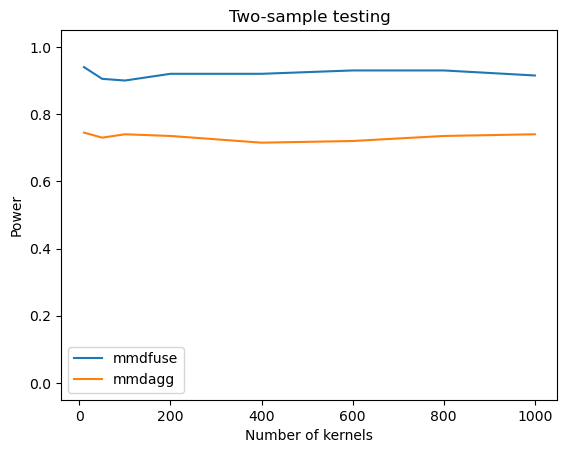

In [7]:
# plot results

tests_labels = ('mmdfuse', 'mmdagg')
for t in range(len(tests)):
    # multiplied by two because both gaussian and laplace
    plt.plot(jnp.array(kernels) * 2, outputs[t], label=tests_labels[t])
plt.legend()
plt.xlabel('Number of kernels')
plt.ylabel('Power')
plt.ylim(-0.05, 1.05)
plt.title('Two-sample testing')